# 🍿 Final project - The Movie Database

For this project, we have targeted movies to analyze them and predict:
- A budget a movie must be allocated, to achieve a certain amount of revenue, public appreciation and popularity (Numerical);
- The single or multiple genres of a movie, by providing its text overview (Textual).

Imports we will be using for the project

In [18]:
import requests
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

In [ ]:
API_KEY=""

## How did we collect the data?
> The Movie Database (TMDB) is a public API which provides lot of data about movies, series and TV Show including descriptions, title, ratings, and more.

We need to get the IDs of the movies we'd like to collect. TMDB uses a system of pages, where each page contains a list of movies

In [ ]:
def get_full_array(page):
    try:
        url = f"https://api.themoviedb.org/3/discover/movie?page={page}"
        headers = {
            "accept": "application/json",
            "Authorization": f"Bearer {API_KEY}"
        }

        response = requests.get(url, headers=headers).text
        data = json.loads(response)
        return [movie['id'] for movie in data['results']]
    except Exception as e:
        return []

IDs = []
for page in tqdm(range(1, 700)):
    IDs += get_full_array(page)



100%|██████████| 699/699 [00:44<00:00, 15.70it/s]


In [ ]:
IDs # List of movie IDs

[552524,
 1233413,
 950387,
 757725,
 870028,
 1257960,
 1197306,
 1411773,
 574475,
 575265,
 299536,
 315635,
 436969,
 1284120,
 284054,
 321612,
 1241436,
 568770,
 1232546,
 822119,
 376867,
 11544,
 297762,
 1241894,
 1199974,
 447273,
 1397832,
 1417059,
 293167,
 541671,
 977294,
 181808,
 1232933,
 464052,
 497698,
 1403735,
 299534,
 986056,
 1241982,
 567609,
 567609,
 680,
 324544,
 339846,
 1233069,
 302946,
 299537,
 1245165,
 897160,
 1087192,
 1144430,
 1011477,
 676685,
 896536,
 1098006,
 1001414,
 1064213,
 320288,
 668489,
 1165642,
 319,
 1297028,
 1010818,
 1480799,
 1094473,
 1087192,
 831973,
 939243,
 1040159,
 429,
 19971,
 762509,
 20760,
 715287,
 7451,
 1010581,
 912649,
 667216,
 793387,
 1448938,
 1195506,
 1225915,
 519182,
 533535,
 1124620,
 575264,
 968171,
 1092073,
 950396,
 1377424,
 1112466,
 1103857,
 1359977,
 933260,
 1153714,
 1414048,
 1022789,
 345940,
 9532,
 1318856,
 1126166,
 1184918,
 811941,
 1092899,
 539972,
 883954,
 383498,
 115659

Since we have collected the movies's ID, we can now get the detail of each one

In [115]:
data = []
for id in tqdm(range(len(IDs))):
    id = IDs[id]
    url = f"https://api.themoviedb.org/3/movie/{id}"
    headers = {
        "accept": "application/json",
        "Authorization": f"Bearer {API_KEY}"
    }
    response = requests.get(url, headers=headers).text
    movie = json.loads(response)
    data.append(movie)

100%|██████████| 10000/10000 [22:13<00:00,  7.50it/s]


We convert the array into `Pandas` dataframe

In [ ]:
df = pd.DataFrame(data)
pd.set_option('display.max_columns', None) # To display all columns
df.to_pickle("all_data.pkl") # Save DataFrame to a pickle file (To directly use the DataFrame later, instead of re-fetching)
df

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,origin_country,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,/7Zx3wDG5bBtcfk8lcnCWDOLM4Y4.jpg,None,100000000,"[{'id': 10751, 'name': 'Family'}, {'id': 35, '...",https://movies.disney.com/lilo-and-stitch-2025,552524,tt11655566,[US],en,Lilo & Stitch,The wildly funny and touching story of a lonel...,554.7778,/tUae3mefrDVTgm5mRzqWnZK6fOP.jpg,"[{'id': 2, 'logo_path': '/wdrCwmRnLFJhEoH8GSfy...","[{'iso_3166_1': 'US', 'name': 'United States o...",2025-05-17,632673317,108,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,Hold on to your coconuts.,Lilo & Stitch,False,7.100,500
1,False,/nAxGnGHOsfzufThz20zgmRwKur3.jpg,"{'id': 1489663, 'name': 'Sinners Collection', ...",90000000,"[{'id': 27, 'name': 'Horror'}, {'id': 28, 'nam...",https://www.sinnersmovie.com,1233413,tt31193180,[US],en,Sinners,"Trying to leave their troubled lives behind, t...",499.7936,/yqsCU5XOP2mkbFamzAqbqntmfav.jpg,"[{'id': 174, 'logo_path': '/zhD3hhtKB5qyv7ZeL4...","[{'iso_3166_1': 'US', 'name': 'United States o...",2025-04-16,352221894,138,"[{'english_name': 'Mandarin', 'iso_639_1': 'zh...",Released,Dance with the devil.,Sinners,False,7.500,1162
2,False,/2Nti3gYAX513wvhp8IiLL6ZDyOm.jpg,"{'id': 1461530, 'name': 'The Minecraft Movie C...",150000000,"[{'id': 10751, 'name': 'Family'}, {'id': 35, '...",https://www.minecraft-movie.com,950387,tt3566834,[US],en,A Minecraft Movie,Four misfits find themselves struggling with o...,325.3314,/yFHHfHcUgGAxziP1C3lLt0q2T4s.jpg,"[{'id': 174, 'logo_path': '/zhD3hhtKB5qyv7ZeL4...","[{'iso_3166_1': 'SE', 'name': 'Sweden'}, {'iso...",2025-03-31,948128918,101,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Be there and be square.,A Minecraft Movie,False,6.502,1674
3,False,/v67tbCB03CMcJRWit8CS7JdJp6.jpg,None,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",https://www.shadowforce.movie,757725,tt11092020,[US],en,Shadow Force,Kyrah and Isaac were once the leaders of a mul...,335.1621,/uX6FaNE86a4Xnf1mFFEryvjqB1D.jpg,"[{'id': 1632, 'logo_path': '/cisLn1YAUuptXVBa0...","[{'iso_3166_1': 'US', 'name': 'United States o...",2025-05-01,4307562,103,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Family over everything.,Shadow Force,False,6.315,46
4,False,/yBDvgpyynDsbMyK21FoQu1c2wYR.jpg,"{'id': 870339, 'name': 'The Accountant Collect...",80000000,"[{'id': 80, 'name': 'Crime'}, {'id': 53, 'name...",https://www.amazon.com/salp/theaccountant2?hhf,870028,tt7068946,[US],en,The Accountant²,"When an old acquaintance is murdered, Wolff is...",550.6126,/kMDUS7VmFhb2coRfVBoGLR8ADBt.jpg,"[{'id': 187968, 'logo_path': '/xdVAEg1biNrQw5n...","[{'iso_3166_1': 'US', 'name': 'United States o...",2025-04-23,101449750,133,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Do you like puzzles?,The Accountant²,False,7.183,320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,/1MFURVRRsZCap7yG6CPxLbXFFMC.jpg,"{'id': 680712, 'name': 'L♡DK コレクション', 'poster_...",0,"[{'id': 10749, 'name': 'Romance'}]",,578672,tt9105026,[JP],ja,L♡DK ひとつ屋根の下、「スキ」がふたつ。,Aoi Nishimori and Shūsei Kugayama are in love ...,2.5352,/8L66hJyXptS9XBt5b4O7WkZuwYj.jpg,"[{'id': 133840, 'logo_path': None, 'name': 'Vi...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2019-03-21,0,107,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,,L♡DK: Two Loves Under One Roof,False,5.700,34
9996,False,/cgmGPmyeShz9zM9GQM5EEgMutnd.jpg,None,5500000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",https://tickets.greed-film.com/,567598,tt8972256,"[GB, US]",en,Greed,A retail billionaire's 60th birthday party is ...,2.3960,/mZPmDFlVp1BSGQD4QCKHOwbXLfv.jpg,"[{'id': 6705, 'logo_path': '/iNB1FCwT4XjO6wkN3...","[{'iso_3166_1': 'GB', 'name': 'United Kingd

## Preprocessing data

### Importing and filtering data 

In case we already have fetched the data, we can load the dataframe using the following command.

In [3]:
df = pd.read_pickle("all_data.pkl")

Since the project is based on French datas, we filter the movies by their `original_language` attribute

In [4]:
copy_df = df.copy()
fr_data = copy_df[copy_df['original_language'] == "fr"]
fr_data

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,origin_country,original_language,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
50,False,/4A5HH9HkCPqAwyYL6CnA0mxbYjn.jpg,"{'id': 1002775, 'name': 'Lost Bullet Collectio...",0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",https://www.netflix.com/title/81701729,1144430,tt29768333,[FR],fr,...,2025-05-06,0,111,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,,Last Bullet,False,6.648,165
64,False,/bIh56F8e5EaZ3r2nD1hXAOisItZ.jpg,None,0,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751...",https://www.gedeonmediagroup.com/en/production...,1094473,tt32373637,[FR],fr,...,2024-10-16,1419154,77,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,,Bambi: A Life in the Woods,False,6.042,24
90,False,/lS49jyUZg9xHfelHMsmL3o3H6rq.jpg,None,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",,1112466,tt27721737,[FR],fr,...,2024-11-15,0,105,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,,The Balconettes,False,6.438,56
99,False,/jzo95EcgXHcVrJQFDqoLSf3TJSF.jpg,None,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",,1318856,tt36462054,[FR],fr,...,2025-05-30,0,81,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,,The Neverending Wedding,False,4.500,17
111,False,/1AWjIUgbZYaKbwUH5qoJaKCcRkf.jpg,None,0,"[{'id': 99, 'name': 'Documentary'}]",https://www.unity-house.co/van-gogh-by-vincent,1471014,tt36364552,[US],fr,...,2025-03-26,0,46,[],Released,,Van Gogh by Vincent,False,5.941,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9796,False,/uLg9t6c34soxT4UAebbL3Cnlbl5.jpg,None,25000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",,77459,tt0961097,[FR],fr,...,2011-10-12,26611650,90,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,You can find love anywhere… even in insects,A Monster in Paris,False,6.900,1281
9813,False,/cHpBJ6EhBj2ZVCvMIsd8RJuoIjU.jpg,None,5133623,"[{'id': 35, 'name': 'Comedy'}]",,761,tt0074103,[FR],fr,...,1976-10-27,0,104,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,,The Wing or the Thigh?,False,7.213,902
9899,False,/8Df8Wsstu76Wr8cTPfNHrSveVe6.jpg,None,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",,869617,tt14700948,[FR],fr,...,2021-09-29,0,88,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,,Friendzone,False,5.878,266
9918,False,/b6UXXuRQL3teEMVKTyae5hTq8ke.jpg,None,0,"[{'id': 35, 'name': 'Comedy'}]",,671043,tt13079150,[FR],fr,...,2021-09-15,0,100,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,,Spoiled Brats,False,6.035,569


Let's show the plots related to the collected data

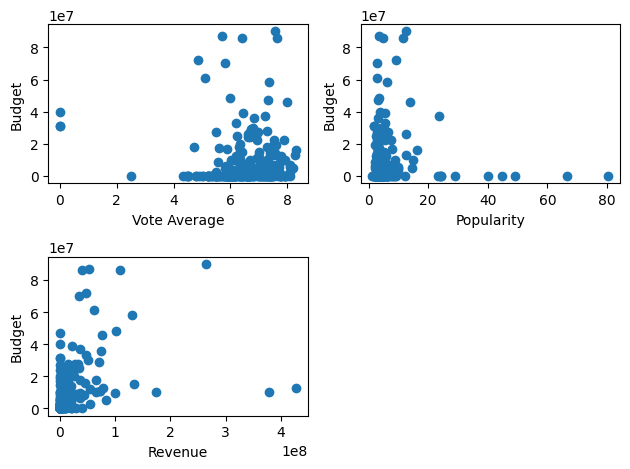

In [5]:
fig, ax = plt.subplots(2,2)

ax[0][0].scatter(fr_data['vote_average'], fr_data['budget'])
ax[0][0].set_xlabel('Vote Average')
ax[0][0].set_ylabel('Budget')

ax[0][1].scatter(fr_data['popularity'], fr_data['budget'])
ax[0][1].set_xlabel('Popularity')
ax[0][1].set_ylabel('Budget')

ax[1][0].scatter(fr_data['revenue'], fr_data['budget'])
ax[1][0].set_xlabel('Revenue')
ax[1][0].set_ylabel('Budget')

ax[1][1].axis('off')

plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

### Numerical values

In [ ]:
filtered_num_df = fr_data[(fr_data['revenue'] > 0) & (fr_data['budget'] > 0)] # Some movies do not have revenue or budget data
numerical_num_df = filtered_num_df[["budget", "vote_average", "revenue", "popularity"]] # Extracting numerical columns

# TODO: std after splitting into train and test sets
scaler = StandardScaler()
df_standardized_numerical = pd.DataFrame(scaler.fit_transform(numerical_num_df), columns=numerical_num_df.columns) # Standardizing the numerical features

X = df_standardized_numerical[['revenue', 'vote_average', 'popularity']]
y = df_standardized_numerical['budget']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_num_df

,budget,vote_average,revenue,popularity
210,37315205,7.231,36010728,23.5463
342,16000000,8.301,45284974,16.3210
399,10000000,6.211,4772,15.0576
575,46000000,8.000,75360860,13.7496
576,86000000,7.631,40208268,11.4611
...,...,...,...,...
9467,22400000,6.943,13000000,2.9107
9486,12500000,7.771,78599508,2.3565
9707,10500000,6.300,64433844,3.0078
9796,25000000,6.900,26611650,2.5082


### Textual values

For the textual part, we have analyzed it as a multi-labelling problem, which means that a movie's overview can belong to several `genres`.

In [21]:
df_text = fr_data[['overview', 'genres']]
df_text.loc[:, 'genres'] = df_text['genres'].apply(lambda x: ','.join([i['name'] for i in x]))
df_text

,overview,genres
50,Car genius Lino returns to conclude his vendet...,"Action,Crime,Thriller,Drama"
64,"The life of Bambi, a male roe deer, from his b...","Adventure,Family,Documentary"
90,As a heat wave brings a Marseille neighbourhoo...,"Comedy,Horror,Fantasy"
99,When carefree Paul and reluctant maid of honor...,"Comedy,Romance,Fantasy"
111,"In a career that lasted only ten years, Vincen...",Documentary
...,...,...
9796,"Paris, 1910. Emile, a shy movie projectionist,...","Adventure,Animation,Comedy,Family,Fantasy"
9813,"Charles Duchemin, a well-known gourmet and pub...",Comedy
9899,Hopeful romantic Thibault believes his luck co...,"Romance,Comedy"
9918,The billionaire is tired of the whims of his o...,Comedy


## Implementation of models

### Numerical values 

For the numerical values, we are going to use a Logistic Regression

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² Score:", r2)

Mean Squared Error: 1.3063376231622326
R² Score: 0.2522665155631384


### Textual values

For the classification, the model needs all the target possibilities

In [23]:
all_genres = set()
for genres in df_text['genres']:
    all_genres.update(genres.split(','))
all_genres = sorted(list(all_genres))
all_genres

['',
 'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War']

Training with multi-label binarizer

In [24]:
mlb = MultiLabelBinarizer(classes=all_genres)
df_text.loc[:, 'genres_list'] = df_text['genres'].apply(lambda x: x.split(','))
y = mlb.fit_transform(df_text['genres_list']) # We embed the target

X_train, X_test, y_train, y_test = train_test_split(
    df_text['overview'],
    y,
    test_size=0.2,
    random_state=42
)


/tmp/ipykernel_28984/2538498902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text.loc[:, 'genres_list'] = df_text['genres'].apply(lambda x: x.split(','))


Vectorizing the text with TF-IDF, which was the best vectorizer in the second lab 

In [25]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_text = vectorizer.fit_transform(X_train)

In [ ]:
# TODO: what purpose?
model = OneVsRestClassifier(LogisticRegression())
model.fit(X_train_text, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [ ]:
y_pred = model.predict(vectorizer.transform(X_test))
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

                 precision    recall  f1-score   support

                      0.00      0.00      0.00         0
         Action       0.00      0.00      0.00        14
      Adventure       0.00      0.00      0.00         9
      Animation       0.00      0.00      0.00         6
         Comedy       0.00      0.00      0.00        15
          Crime       0.00      0.00      0.00         7
    Documentary       0.00      0.00      0.00         1
          Drama       0.54      1.00      0.70        25
         Family       0.00      0.00      0.00         6
        Fantasy       0.00      0.00      0.00         9
        History       0.00      0.00      0.00         2
         Horror       0.00      0.00      0.00         5
          Music       0.00      0.00      0.00         1
        Mystery       0.00      0.00      0.00         4
        Romance       0.00      0.00      0.00        10
Science Fiction       0.00      0.00      0.00         2
       TV Movie       0.00    

/home/wsl/ml/machine-learning-efrei-s8/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wsl/ml/machine-learning-efrei-s8/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wsl/ml/machine-learning-efrei-s8/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

In [28]:
new_overview = ["A futuristic city where a detective must solve a series of crimes using advanced technology.",]
X_new = vectorizer.transform(new_overview)
y_new = model.predict(X_new)
predicted_genres = mlb.inverse_transform(y_new)
print("Predicted genres:", predicted_genres)

Predicted genres: [('Drama',)]
